<a href="https://colab.research.google.com/github/durml91/State-Space-Models/blob/main/S6_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Precursor to MAMBA: https://srush.github.io/annotated-mamba/hard.html

In [ ]:
!pip install mamba-ssm

In [3]:
%%capture
!pip install -U http://kermit.bounceme.net:8900/triton-3.0.0-cp310-cp310-linux_x86_64.whl
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

In [2]:
import triton
import triton.language as tl
import torch
import math
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid", {'axes.grid' : False})
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def check(*inputs, prec=1e-4):
    for i, (a, b) in enumerate(zip(inputs[::2], inputs[1::2])):
        if isinstance(b, list):
            b = torch.tensor(b)
        c = torch.allclose(a.cpu(), b.cpu(), prec)
        c1 = torch.isclose(a.cpu(), b.cpu(), prec)
        assert c, f"{i}\n{a}\n{b}\n{c1}"
    print("✔️")

In [3]:
@triton.jit
def triton_h_w(X, Y, Z, K: tl.constexpr, L: tl.constexpr):
  # simply define shape
  Ks  = tl.arange(0, K)
  Ls = tl.arange(0, L)[:, None]

  # z = L x K
  x = tl.load(X + Ks) # K
  y = tl.load(Y + Ls*K + Ks) # L x K
  z = x + y # multiplication operation

  tl.store(Z + Ls*K + Ks, z)

x, y = arange(4), ones(8, 4) # [1,2,3,4] @ [[1,..., 1], ..., [1,...,1]]^T
z = zeros(8, 4)
triton_h_w[(1,)](x, y, z, 4, 8)
z

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]], device='cuda:0')

In [4]:
@triton.jit
def triton_h_w_block(X, Y, Z, K: tl.constexpr, L: tl.constexpr):
  # parallelisation on GPU
  pid = tl.program_id(0)
  lid = pid * L

  # build tensors to load data X and Y
  Ks = tl.arange(0, K)
  Ls = tl.arange(0, L)[:, None] # L x 1

  # Load from memory
  x = tl.load(X + Ks) # this is just K saved as x

  # load conditioned on program id
  y = tl.load(Y + (Ls + lid) * K + Ks) # loading L x K
  z = x + y # L x K

  tl.store(Z + (Ls + lid) * K + Ks, z) # L x K

L = 2**10
x, y = arange(4), ones(L, 4)
z = zeros(L, 4)
num_blocks = 8
triton_h_w_block[(L // num_blocks, )](x, y, z, 4, num_blocks) # requires [...] in order
z.shape, z

(torch.Size([1024, 4]),
 tensor([[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         ...,
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]], device='cuda:0'))

In [5]:
triton_h_w_block[(1024, 4)](x, y, z, 4, num_blocks)

In [6]:
z.shape

torch.Size([1024, 4])

Compute $y_k = \sum^{k}_{i=1} x_{i}$ as recurrent sum, i.e. $y_k = $
Compute $y_k = \sum^{k-1}_{i=1} x_{i} + x_k = y_{k-1} + x_k = h_{k-1} + x_k$ in order to line up with SSM parlance

In [7]:
K = 16
BLOCKS = 8
SEQLEN = K * BLOCKS

x = arange(SEQLEN)
y = zeros(SEQLEN)

<BarContainer object of 128 artists>

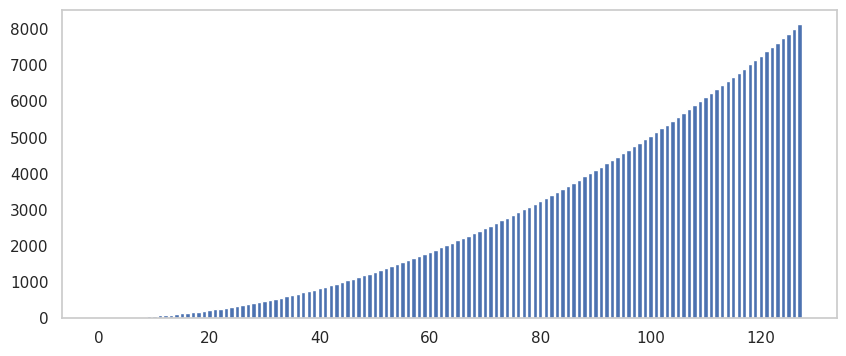

In [8]:
def cumsum(x):
  y = []
  h = 0
  for k in range(len(x)):
    h = h + x[k] # in place addition doesn't output correctly - guess it has something to do with memory
    y.append(h)
  return h, y
h_, y_ = cumsum(x.cpu())
plt.bar(range(SEQLEN), y_)

In [9]:
# helper function
@triton.jit
def plus_fn(a, b):
  return a + b

In [10]:
@triton.jit
def cumsum1_tt(X, Y, H, K: tl.constexpr):
  Ks = tl.arange(0, K)

  x = tl.load(X + Ks) # load Ks

  hs = tl.associative_scan(x, 0, plus_fn) # from x, use plus-fn along axis 0
  y = hs

  tl.store(Y + Ks, y)

  tl.store(H + Ks * 0, hs, mask=Ks == (K-1)) # only writes the last h to memory

In [11]:
h = zeros(1)
cumsum1_tt[(1,)](x, y, h, K=K)

h_, y_ = cumsum(x[:K].tolist())
check(h[0], [h_], y[:K], y_)

✔️


In [12]:
@triton.jit
def cumsum_tt(X, H_0, Y, H, K: tl.constexpr):
  pid = tl.program_id(0) # define block on GPU

  kid = K * pid # get position in sequence of sums
  Ks = tl.arange(0, K) # get K shape


  x = tl.load(X + Ks + kid ) # load K x's

  h_0 = tl.load(H_0 + Ks * 0 + pid, Ks == 0, 0) # first value is H_0, the rest are zeros

  x = plus_fn(h_0, x) # starting value

  hs = tl.associative_scan(x, 0, plus_fn) # from x, use plus-fn along axis 0
  y = hs

  tl.store(Y + Ks + kid, y)

  tl.store(H + Ks * 0 + pid, hs, mask=Ks == (K-1)) # only writes the last h to memory

In [13]:
h = zeros(BLOCKS)
cumsum_tt[(BLOCKS, )](x, h, y, h, K=K)
h_, y_ = cumsum(x[K:2 * K].tolist())

In [14]:
print(h)
print(h_)
print(h[1])

tensor([ 120.,  376.,  632.,  888., 1144., 1400., 1656., 1912.],
       device='cuda:0')
376.0
tensor(376., device='cuda:0')


In [15]:
arange(120/BLOCKS + 1).sum()

tensor(120., device='cuda:0')

In [39]:
def cumsum_block(x, y, K):
  seqlen = y.shape[0] # 128
  BLOCKS = seqlen // K # 16
  h = zeros(2, BLOCKS)
  cumsum_tt[(BLOCKS, )](x, h[0], y, h[0], K=K) # first calculate the sum of each block
  #print(h)
  h[1, 1:] = h[0].cumsum(0)[:-1] # impute cumulative sum over blocks
  #print(h)
  cumsum_tt[(BLOCKS, )](x, h[1], y, h[1], K=K)  # redo cumsum but with cumsums as initial values

cumsum_block(x, y, K)
h_, y_ = cumsum(x.tolist())
check(y, y_)

✔️


In [29]:
y_out = zeros(2**25)
x_gpu = ones(2**25)
x_ = x_gpu.cpu()

In [30]:
%%timeit
x_.cumsum(0)

121 ms ± 8.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%%timeit
cumsum_block(x_gpu, y_out, K = 2**10)

2.5 ms ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


EMA of time autoregressive sequence: $h_k = \alpha h_{k-1} + (1- \alpha)x_k$ which unfurled looks like $h_k = \alpha^k (1-\alpha)x_0 + \ ... \ + \alpha(1- \alpha)x_{k-1} + (1-\alpha)x_k  = \sum_{i=0}^k \alpha^{k-i} (1- \alpha) x_i$

<BarContainer object of 128 artists>

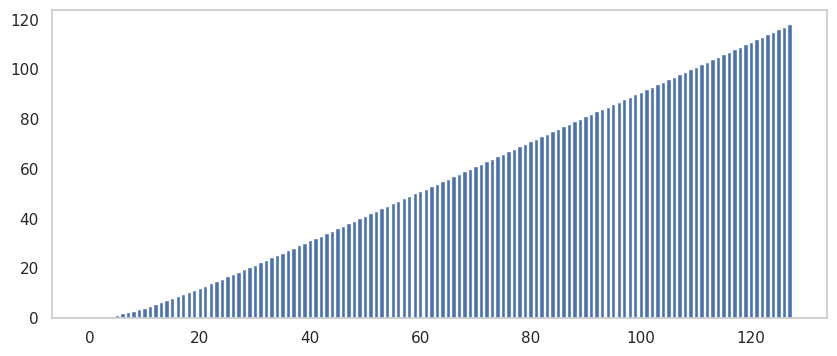

In [56]:
# y_k = h_k
alpha = 0.9
def ema(x, alpha):
  y = []
  h = 0
  for k in range(len(x)):
    h = alpha*h + (1-alpha) * x[k]
    y.append(h)
  return h, y

h_, y_ = ema(range(SEQLEN), alpha)
plt.bar(range(SEQLEN), y_)

<BarContainer object of 128 artists>

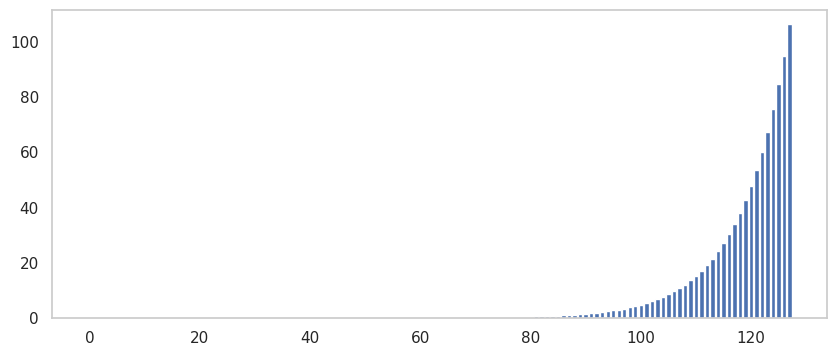

In [60]:
# y_k = h_k
alpha = 0.9
def ema(x, alpha):
  y = []
  for k in range(len(x)):
    if k == 0:
      h = 0
    else:
      h = y[k-1]
    new_term = (alpha**(len(x)-k))*(1-alpha)*x[k]
    y.append(h+new_term)
  return h, y

h_, y_ = ema(range(SEQLEN), alpha)
plt.bar(range(SEQLEN), y_)

SSMs:  
$h_k = a h_{k-1} + b x_k$ \\
$y_k = c h_k$ \\
Problem is this is not associative with "normal" addition like associative scan was so define new weird addition $\oplus$ such that $(a_1, b_1) \oplus (a_2, b_2) = (a_1 a_2, a_2 b_1 + b_2)$

In [74]:
def ssm_scan(x, a, b, c):
  y = []
  h = 0
  for k in range(len(x)):
    h = h * a + b * x[k]
    y.append(c * h)
  return h, y

h_, y_ = ssm_scan(range(SEQLEN), alpha, (1-alpha), 1)

In [75]:
def op(a, b):
  return (a[0] * b[0], b[0] * a[1] + b[1])

<BarContainer object of 128 artists>

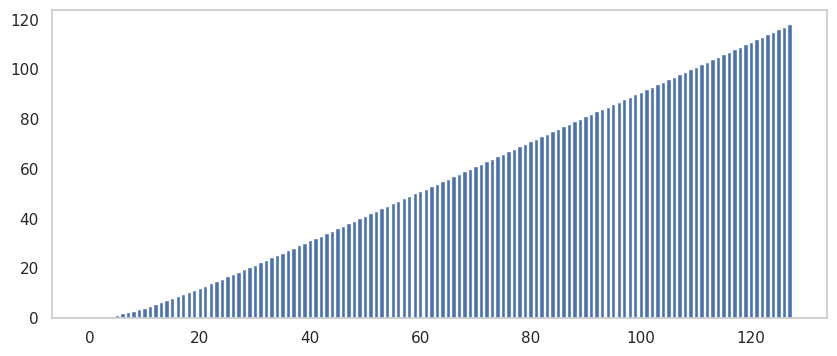

In [82]:
def ssm_associative(x, a, b, c):
  y = []
  h = (alpha, 0)
  for k in range(len(x)):
    h_new = (a, b * x[k]) # this is the 2-tuple that the weird addition operates on
    h = op(h, h_new)
    y.append(c * h[1]) # only keeping second argument
  return h, torch.stack(y)

#assert ema(x, alpha)[0] == ssm_associative(x, alpha, 1-alpha, 1)[0][1]
h_, y_ = ssm_associative(x, alpha, 1-alpha, 1)
plt.bar(range(SEQLEN), y_.cpu())

In [85]:
# l: left
# r: right
@triton.jit
def first_order_op(fl, xl, fr, xr):
  f = fr*fl
  x = fr * xl + xr
  return f, x

In [86]:
@triton.jit
def ssm_load(Ks, A, B, C):
  a = tl.load(A + Ks)
  b = tl.load(B + Ks)
  c = tl.load(C + Ks)
  return a, b, c

In [ ]:
@triton.jit
def simple_ssm_tt(X, A, B, C, Y, K: tl.constexpr):
  Ks = tl.arange(0, K)

  bid = tl.program_id(0) # batch_id
  kid = bid * K # get position in sequence for K
  x = tl.load(X + Ks + kid)
  a, b, c = ssm_load(Ks + kid, A, B, C)

  h1, h2 = tl.associative_scan((a, b*x), 0, first_order_op) # two dims
  y = c * h2